## Predicting the Number of Bike Trips in SF

The goal of this project is to determine the number of the trips that will take place in San Franscisco on a given day. The data set can be obtained from Kaggle by following the given [link](https://www.kaggle.com/benhamner/sf-bay-area-bike-share).
The predictive models used is Random Forest Classifier, Gradient Boosting Regressor etc.

### Load the packages

In [1]:
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, median_absolute_error

### Import the Data

In [2]:
df = pd.read_csv("trip.csv")
weather = pd.read_csv("weather.csv")
stations = pd.read_csv("station.csv")

In [3]:
#Explore the trips dataset
df.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In [4]:
df.isnull().sum()

id                       0
duration                 0
start_date               0
start_station_name       0
start_station_id         0
end_date                 0
end_station_name         0
end_station_id           0
bike_id                  0
subscription_type        0
zip_code              6619
dtype: int64

In [5]:
df.duration.describe()

count    6.699590e+05
mean     1.107950e+03
std      2.225544e+04
min      6.000000e+01
25%      3.440000e+02
50%      5.170000e+02
75%      7.550000e+02
max      1.727040e+07
Name: duration, dtype: float64

In [6]:
# Convert the duration from seconds to minutes
df.duration /= 60

In [7]:
df.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,1.050000,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,1.166667,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,1.183333,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,1.283333,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,1.383333,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In [8]:
df['duration'].quantile(0.995)


343.9201666666661

In [8]:
#Remove the entries that have a duration of more than 6 hours
df = df[df.duration <= 360]

In [9]:
df.shape

(666872, 11)

In [13]:
df.start_date = pd.to_datetime(df.start_date, format='%m/%d/%Y %H:%M')

In [14]:
df['date'] = df.start_date.dt.date

In [15]:
#Find the total number of trips taken in a day
dates = {}
for d in df.date:
    if d not in dates:
        dates[d] = 1
    else:
        dates[d] += 1

In [16]:
#Create a dataframe with columns as date and number of trips for that particular day
train = pd.DataFrame(list(dates.items()), columns=['date', 'trips'])

In [17]:
train.head()

,date,trips
0,2015-02-06,608
1,2015-03-20,1203
2,2013-12-10,877
3,2013-10-22,1026
4,2014-12-28,296


In [18]:
train = train.sort_values(by=['date'])
train.reset_index(drop=True, inplace=True)

In [19]:
train.head()

,date,trips
0,2013-08-29,742
1,2013-08-30,699
2,2013-08-31,628
3,2013-09-01,683
4,2013-09-02,652


### Explore the Weathers Dataframe

In [20]:
weather.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,8/29/2013,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,8/30/2013,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,8/31/2013,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,9/1/2013,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,9/2/2013,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


In [21]:
weather.isnull().sum()

date                                 0
max_temperature_f                    4
mean_temperature_f                   4
min_temperature_f                    4
max_dew_point_f                     54
mean_dew_point_f                    54
min_dew_point_f                     54
max_humidity                        54
mean_humidity                       54
min_humidity                        54
max_sea_level_pressure_inches        1
mean_sea_level_pressure_inches       1
min_sea_level_pressure_inches        1
max_visibility_miles                13
mean_visibility_miles               13
min_visibility_miles                13
max_wind_Speed_mph                   1
mean_wind_speed_mph                  1
max_gust_speed_mph                 899
precipitation_inches                 1
cloud_cover                          1
events                            3143
wind_dir_degrees                     1
zip_code                             0
dtype: int64

In [22]:
weather.date = pd.to_datetime(weather.date, format='%m/%d/%Y')

In [23]:
print(train.shape)
print(weather.shape)

(733, 2)
(3665, 24)


In [24]:
weather = weather[weather.zip_code == 94107]

In [25]:
weather.events.unique()

array([nan, 'Fog', 'Rain', 'Fog-Rain', 'rain', 'Rain-Thunderstorm'],
      dtype=object)

In [26]:
weather.loc[weather.events == 'rain', 'events'] = "Rain"
weather.loc[weather.events.isnull(), 'events'] = "Normal"

In [27]:
weather.events.unique()

array(['Normal', 'Fog', 'Rain', 'Fog-Rain', 'Rain-Thunderstorm'],
      dtype=object)

In [28]:
events = pd.get_dummies(weather.events)

In [29]:
events

,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0
5,0,0,1,0,0
6,0,0,1,0,0
7,0,0,1,0,0
8,0,0,1,0,0
9,0,0,1,0,0


In [30]:
weather = weather.merge(events, left_index = True, right_index = True)

In [31]:
weather = weather.drop(['events','zip_code'],1)

In [32]:
#max_wind and max_gust are well correlated, so we can use max_wind to help fill the null values of max_gust
print(pearsonr(weather.max_wind_Speed_mph[weather.max_gust_speed_mph >= 0], 
               weather.max_gust_speed_mph[weather.max_gust_speed_mph >= 0]))

(0.7888476832259106, 6.027203207271524e-154)


In [33]:
#For each value of max_wind, find the median max_gust and use that to fill the null values.#For eac 
weather.loc[weather.max_gust_speed_mph.isnull(), 'max_gust_speed_mph'] =weather.groupby('max_wind_Speed_mph').max_gust_speed_mph.apply(lambda x: x.fillna(x.median()))

In [34]:
weather.isnull().sum()

date                              0
max_temperature_f                 0
mean_temperature_f                0
min_temperature_f                 0
max_dew_point_f                   0
mean_dew_point_f                  0
min_dew_point_f                   0
max_humidity                      0
mean_humidity                     0
min_humidity                      0
max_sea_level_pressure_inches     0
mean_sea_level_pressure_inches    0
min_sea_level_pressure_inches     0
max_visibility_miles              0
mean_visibility_miles             0
min_visibility_miles              0
max_wind_Speed_mph                0
mean_wind_speed_mph               0
max_gust_speed_mph                0
precipitation_inches              0
cloud_cover                       0
wind_dir_degrees                  0
Fog                               0
Fog-Rain                          0
Normal                            0
Rain                              0
Rain-Thunderstorm                 0
dtype: int64

In [35]:
weather.precipitation_inches = pd.to_numeric(weather.precipitation_inches, errors = 'coerce')

In [36]:
#Fill the null values with the median value
weather.loc[weather.precipitation_inches.isnull(), 
            'precipitation_inches'] = weather[weather.precipitation_inches.notnull()].precipitation_inches.median()

In [37]:
train = train.merge(weather, on = train.date)

In [38]:
train.head()

,key_0,date_x,trips,date_y,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,...,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm
0,2013-08-29,2013-08-29,742,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,...,11.0,28.0,0.0,4.0,286.0,0,0,1,0,0
1,2013-08-30,2013-08-30,699,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,...,13.0,35.0,0.0,2.0,291.0,0,0,1,0,0
2,2013-08-31,2013-08-31,628,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,...,15.0,31.0,0.0,4.0,284.0,0,0,1,0,0
3,2013-09-01,2013-09-01,683,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,...,13.0,29.0,0.0,4.0,284.0,0,0,1,0,0
4,2013-09-02,2013-09-02,652,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,...,12.0,30.0,0.0,6.0,277.0,0,0,1,0,0


In [39]:
train['date'] = train['date_x']
train.drop(['date_y','date_x'],1, inplace= True)

In [40]:
train.columns

Index(['key_0', 'trips', 'max_temperature_f', 'mean_temperature_f',
       'min_temperature_f', 'max_dew_point_f', 'mean_dew_point_f',
       'min_dew_point_f', 'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'max_gust_speed_mph', 'precipitation_inches',
       'cloud_cover', 'wind_dir_degrees', 'Fog', 'Fog-Rain', 'Normal', 'Rain',
       'Rain-Thunderstorm', 'date'],
      dtype='object')

### Explore the Stations Dataframe

In [42]:
stations.head()

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [43]:
print(len(stations.name.unique()))
print(stations.shape)

70
(70, 7)


In [44]:
stations.installation_date = pd.to_datetime(stations.installation_date, format = "%m/%d/%Y").dt.date

In [45]:
print(stations.installation_date.min())
print(stations.installation_date.max())

2013-08-05
2014-04-09


In [46]:
#For each day, find the total number of installed parking slots on that day or before that day
total_docks = []
for day in train.date:
    total_docks.append(sum(stations[stations.installation_date <= day].dock_count))

In [47]:
train['total_docks'] = total_docks

In [48]:
#Find all the holidays
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=train.date.min(), end=train.date.max())

In [49]:
holidays

DatetimeIndex(['2013-09-02', '2013-10-14', '2013-11-11', '2013-11-28',
               '2013-12-25', '2014-01-01', '2014-01-20', '2014-02-17',
               '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13',
               '2014-11-11', '2014-11-27', '2014-12-25', '2015-01-01',
               '2015-01-19', '2015-02-16', '2015-05-25', '2015-07-03'],
              dtype='datetime64[ns]', freq=None)

In [50]:
#Find all the Business Days
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
business_days = pd.DatetimeIndex(start=train.date.min(), end=train.date.max(), freq=us_bd)

In [51]:
business_daysbusiness  = pd.to_datetime(business_days, format='%Y/%m/%d').date
holidays = pd.to_datetime(holidays, format='%Y/%m/%d').date

In [52]:
train['business_day'] = train.date.isin(business_days)
train['holiday'] = train.date.isin(holidays)

In [53]:
train.head()

,key_0,trips,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,...,wind_dir_degrees,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm,date,total_docks,business_day,holiday
0,2013-08-29,742,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,...,286.0,0,0,1,0,0,2013-08-29,1150,False,False
1,2013-08-30,699,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,...,291.0,0,0,1,0,0,2013-08-30,1150,False,False
2,2013-08-31,628,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,...,284.0,0,0,1,0,0,2013-08-31,1150,False,False
3,2013-09-01,683,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,...,284.0,0,0,1,0,0,2013-09-01,1150,False,False
4,2013-09-02,652,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,...,277.0,0,0,1,0,0,2013-09-02,1150,False,True


In [54]:
train.business_day = train.business_day.map(lambda x: 1 if x == True else 0)
train.holiday = train.holiday.map(lambda x: 1 if x == True else 0)

In [55]:
train['year'] = pd.to_datetime(train['date']).dt.year
train['month'] = pd.to_datetime(train['date']).dt.month
train['weekday'] = pd.to_datetime(train['date']).dt.weekday

In [56]:
train.columns

Index(['key_0', 'trips', 'max_temperature_f', 'mean_temperature_f',
       'min_temperature_f', 'max_dew_point_f', 'mean_dew_point_f',
       'min_dew_point_f', 'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'max_gust_speed_mph', 'precipitation_inches',
       'cloud_cover', 'wind_dir_degrees', 'Fog', 'Fog-Rain', 'Normal', 'Rain',
       'Rain-Thunderstorm', 'date', 'total_docks', 'business_day', 'holiday',
       'year', 'month', 'weekday'],
      dtype='object')

In [57]:
labels = train.trips
train = train.drop(['trips', 'date', 'key_0'], 1)

In [58]:
train.head()

,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure_inches,...,Fog-Rain,Normal,Rain,Rain-Thunderstorm,total_docks,business_day,holiday,year,month,weekday
0,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,30.07,...,0,1,0,0,1150,0,0,2013,8,3
1,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,30.05,...,0,1,0,0,1150,0,0,2013,8,4
2,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,30.00,...,0,1,0,0,1150,0,0,2013,8,5
3,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,29.96,...,0,1,0,0,1150,0,0,2013,9,6
4,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,0,1,0,0,1150,0,1,2013,9,0


### Train the model

In [59]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.2, random_state = 2)

In [60]:
def scoring(clf):
    scores = cross_val_score(clf, X_train, y_train, cv=15, n_jobs=1, scoring = 'neg_median_absolute_error')
    print(np.median(scores) * -1)

In [61]:
rfr = RandomForestRegressor(n_estimators = 55,
                            min_samples_leaf = 3,
                            random_state = 2)
scoring(rfr)

56.30199855699834


In [62]:
gbr = GradientBoostingRegressor(learning_rate = 0.12,
                                n_estimators = 150,
                                max_depth = 8,
                                min_samples_leaf = 1,
                                random_state = 2)
scoring(gbr)

55.83298973643241


In [63]:
dtr = DecisionTreeRegressor(min_samples_leaf = 3,
                            max_depth = 8,
                            random_state = 2)
scoring(dtr)

61.5


In [64]:
abr = AdaBoostRegressor(n_estimators = 100,
                        learning_rate = 0.1,
                        loss = 'linear',
                        random_state = 2)
scoring(abr)

102.89675516224179


In [65]:
rfr = rfr.fit(X_train, y_train)
gbr = gbr.fit(X_train, y_train)

rfr_preds = rfr.predict(X_test)
gbr_preds = gbr.predict(X_test)

In [66]:
y_test.reset_index(drop = True, inplace = True)

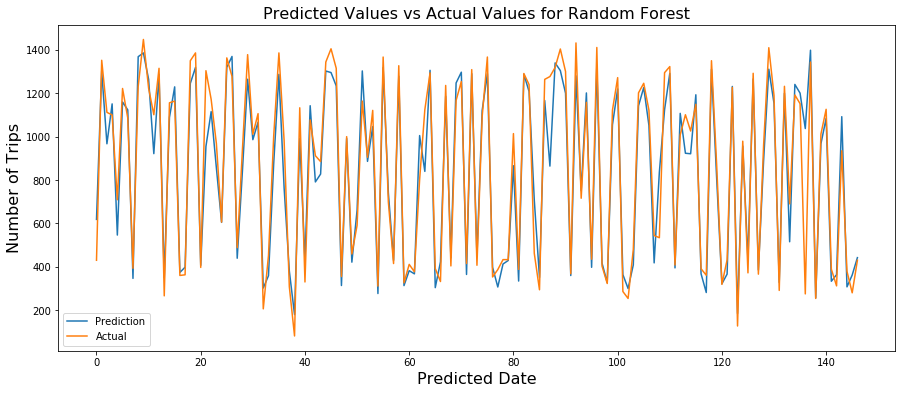

In [67]:
fs = 16
plt.figure(figsize=(15,6))
plt.plot(rfr_preds)
plt.plot(y_test)
plt.legend(['Prediction', 'Actual'])
plt.ylabel("Number of Trips", fontsize = fs)
plt.xlabel("Predicted Date", fontsize = fs)
plt.title("Predicted Values vs Actual Values for Random Forest", fontsize = fs)
plt.show()

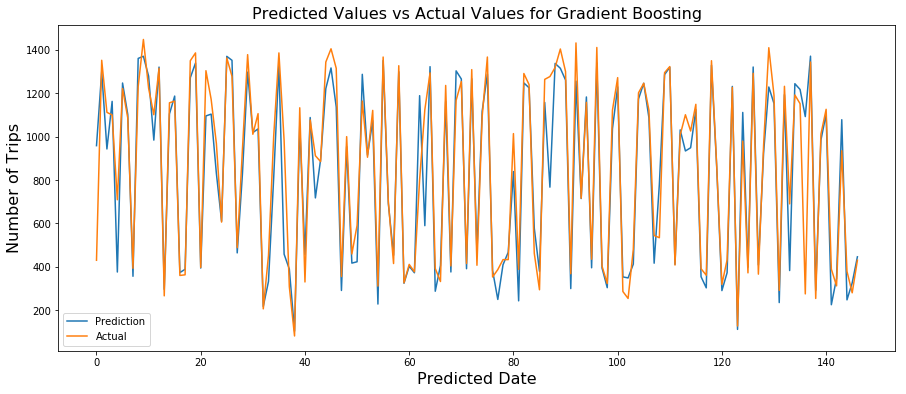

In [68]:
fs = 16
plt.figure(figsize=(15,6))
plt.plot(gbr_preds)
plt.plot(y_test)
plt.legend(['Prediction', 'Actual'])
plt.ylabel("Number of Trips", fontsize = fs)
plt.xlabel("Predicted Date", fontsize = fs)
plt.title("Predicted Values vs Actual Values for Gradient Boosting", fontsize = fs)
plt.show()

In [69]:
def plot_importances(model, model_name):
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for feature in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]    

    # Plot the feature importances of the forest
    plt.figure(figsize = (12,5))
    plt.title("Feature importances of " + model_name)
    plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

Feature ranking:
0 max_temperature_f
1 mean_temperature_f
2 min_temperature_f
3 max_dew_point_f
4 mean_dew_point_f
5 min_dew_point_f
6 max_humidity
7 mean_humidity
8 min_humidity
9 max_sea_level_pressure_inches
10 mean_sea_level_pressure_inches
11 min_sea_level_pressure_inches
12 max_visibility_miles
13 mean_visibility_miles
14 min_visibility_miles
15 max_wind_Speed_mph
16 mean_wind_speed_mph
17 max_gust_speed_mph
18 precipitation_inches
19 cloud_cover
20 wind_dir_degrees
21 Fog
22 Fog-Rain
23 Normal
24 Rain
25 Rain-Thunderstorm
26 total_docks
27 business_day
28 holiday
29 year
30 month
31 weekday


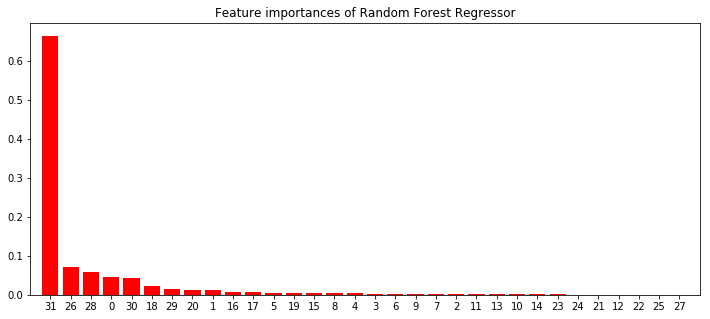

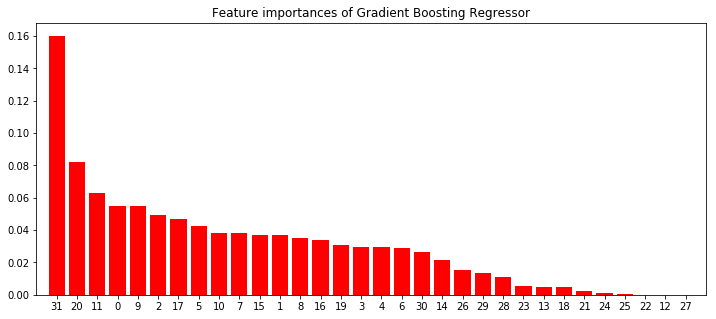

In [70]:
# Print the feature ranking# Print  
print("Feature ranking:")

i = 0
for feature in X_train:
    print (i, feature)
    i += 1
    
plot_importances(rfr, "Random Forest Regressor")
plot_importances(gbr, "Gradient Boosting Regressor")